In [1]:
import simulation
import numpy as np
from scipy.stats import rayleigh

L = 25.0
M = 4

r_values = np.arange(0, 5.01, 0.01)

# 2D standard normal distribution radial density
# The radial distribution for a 2D normal is proportional to Rayleigh distribution with scale 1 (standard normal case)
def density(r):
    return (1 / (2 * np.pi)) * np.exp(-0.5 * r**2)

radial_density_values = density(r_values)
q_values = np.arange(0, 1.0, 0.001)
inverse_radial_values = rayleigh.ppf(q_values, scale=1.0)
g2 = simulation.PyGrid2(
    M=M,
    areaLen=[L, L],
    cellCount=[L, L],
    isPeriodic=True,
    birthRates=[1]*M,
    deathRates=[0]*M,
    ddMatrix=[0.1, 0.5, 0.5, 0.5,
              0.5, 0.1, 0.5, 0.5,
              0.5, 0.5, 0.1, 0.5,
              0.5, 0.5, 0.5, 0.1,],         # 1x1 for single species
    birthX=[q_values.tolist()]*M,     # example
    birthY=[inverse_radial_values.tolist()]*M,
    deathX_=[ [ r_values.tolist()]*M]*M,
    deathY_=[ [ radial_density_values.tolist() ]*M ]*M,
    cutoffs=[5.0]*M*M,
    seed=42,
    rtimeLimit=3600.0
)


# Parameters
N = 1000  # Number of [x, y] pairs per group

# Generate the list
coordinates = []
for _ in range(M):
    group = [[np.random.uniform(0, L), np.random.uniform(0, L)] for _ in range(N)]
    coordinates.append(group)

g2.placePopulation(coordinates)

print("Birth rate:", g2.total_birth_rate)
print("Death rate:", g2.total_death_rate)

Birth rate: 4000.0
Death rate: 10243.619402373417


In [2]:
import pandas as pd

data = list()

for t in range(100):
    for c in range(g2.get_num_cells()):
        for n in range(M):
            coords = g2.get_cell_coords(c,n)
            for i in range(len(coords)):
                x,y = coords[i]
                data.append([t,x,y,n])
    g2.run_for(1)
    print(t, g2.total_population)

0 2110
1 1769
2 1722
3 1849
4 2082
5 2230
6 2435
7 2737
8 2973
9 3319
10 3548
11 3674
12 3903
13 4027
14 4154
15 4420
16 4356
17 4421
18 4389
19 4381
20 4504
21 4532
22 4608
23 4639
24 4851
25 4825
26 4737
27 4724
28 4743
29 4797
30 4791
31 4865
32 4904
33 4873
34 4930
35 4976
36 4962
37 5046
38 4883
39 5007
40 5112
41 5140
42 5104
43 5188
44 5067
45 5116
46 5096
47 5100
48 5002
49 5186
50 5139
51 5140
52 5151
53 5141
54 5249
55 5362
56 5273
57 5295
58 5377
59 5352
60 5531
61 5631
62 5687
63 5580
64 5691
65 5791
66 5848
67 5875
68 5764
69 5635
70 5749
71 5839
72 5847
73 6067
74 5960
75 6139
76 6198
77 6264
78 6245
79 6251
80 6248
81 6174
82 6138
83 6223
84 6216
85 6163
86 6164
87 6146
88 6135
89 6183
90 6232
91 6289
92 6189
93 6185
94 6186
95 6257
96 6273
97 6247
98 6276
99 6295


In [3]:
df = pd.DataFrame(columns=['time','x','y','s'],data=data)
df

,time,x,y,s
0,0,0.991243,0.445259,0
1,0,0.849250,0.748467,1
2,0,0.393963,0.947108,1
3,0,0.868503,0.241255,3
4,0,0.580986,0.174515,3
...,...,...,...,...
503797,99,24.239244,24.526462,3
503798,99,24.665481,24.366068,3
503799,99,24.740663,24.595485,3
503800,99,24.503957,24.344556,3


MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved as points_animation.gif


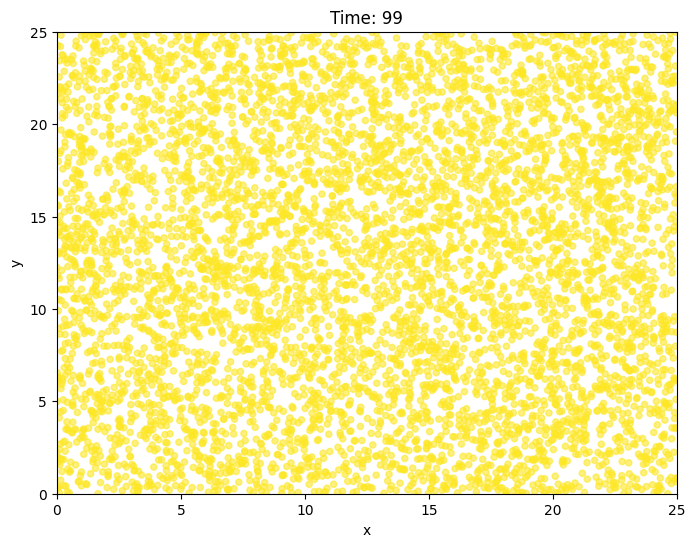

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

df = df.sort_values('time')

# Parameters
output_file = "points_animation.gif"

# MP4 Video Generation
fig, ax = plt.subplots(figsize=(8, 6))

# Set axis limits
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_xlabel('x')
ax.set_ylabel('y')
sc = ax.scatter([], [], c=[], cmap='viridis', s=20, alpha=0.6)

# Animation function
def update(frame):
    current_df = df[df['time'] == frame]
    sc.set_offsets(current_df[['x', 'y']].values)
    sc.set_array(current_df['s'].values)
    ax.set_title(f"Time: {frame}")
    return sc,

ani = FuncAnimation(fig, update, frames=df['time'].nunique(), blit=True)

# Save as MP4
ani.save(output_file, writer="ffmpeg", fps=2)
print(f"Animation saved as {output_file}")